# Ensembles and Predictions Clipping
The combination of predictions from several methods to one forecast often leads to great performance improvements. 

## Simple Ensembles
The most common strategy just takes an average of all the forecast, which often leads to surprisingly good results, for more on this topic, see forecast combination chapter from [Forecasting: Principles and Practice](https://otexts.com/fpp2/combinations.html). hcrystalball implements `SimpleEnsemble` which provides a simple interface for putting together very diverse models. `SimpleEnsemble` model takes a list of any hcrystalball model wrapper instance(s) as base learners and aggregates their prediction using `ensemble_func`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [12, 6]

In [2]:
from hcrystalball.utils import get_sales_data

df = get_sales_data(n_dates=100, 
                    n_assortments=1, 
                    n_states=1, 
                    n_stores=1)
X, y = pd.DataFrame(index=df.index), df['Sales']

In [3]:
from hcrystalball.ensemble import SimpleEnsemble
from hcrystalball.wrappers import ProphetWrapper
from hcrystalball.wrappers import ExponentialSmoothingWrapper
from hcrystalball.wrappers import get_sklearn_wrapper
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [4]:
prophet = ProphetWrapper(
    extra_seasonalities = [{
        'name':'bi-weekly',
        'period': 14.,
        'fourier_order': 5,
        'prior_scale': 15.0,
        'mode': None
    }]
)

In [5]:
simple_ensemble = SimpleEnsemble(
    base_learners=[
        prophet,
        ExponentialSmoothingWrapper(),
        get_sklearn_wrapper(RandomForestRegressor)
    ],
    ensemble_func = 'median')

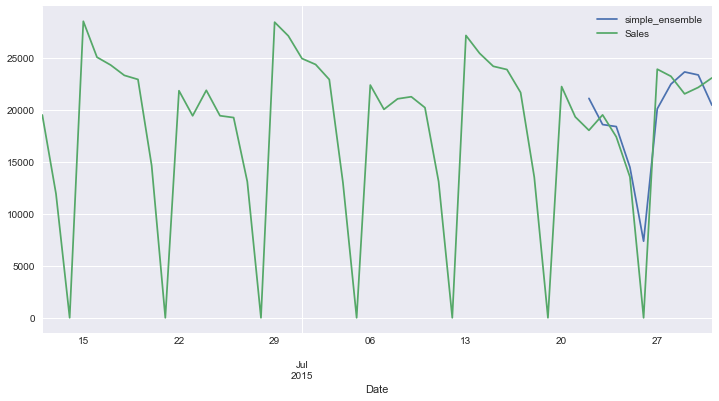

In [6]:
(simple_ensemble.fit(X[:-10], y[:-10])
                .predict(X[-10:])
                .merge(y, left_index=True, right_index=True, how='outer')
                .tail(50)
                .plot()
);

## Stacking Ensembles
hcrystalball `StackingEnsemble` model is very similar to sklearn [StackingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingRegressor.html), nice explanation of the concept could be also found [here](http://rasbt.github.io/mlxtend/user_guide/regressor/StackingCVRegressor/). Unfortunately, the sklearn version of the `StackingEnsemble` doesn't allow us to enrich the `meta_training_data` by other features than predictions of base learners. 

In the case of time-series forecasts, the additional features are the key to enabling the `meta_model` to successfully learn when each model performs best. It's often the case that some model performs better during specific days (i.e. weekends/holidays/spikes) and other is better during more stable periods. The goal is to combine them appropriately. 

To do that you can specify `weekdays_as_features` as `True`, which will enrich the `meta_training_data` with the day of the week features. Another way how to improve the performance of the stacking ensemble is to take into account that some models perform better on short horizons, and some on longer ones. To take this effect into account the `horizons_as_features` can be set to `True`, which creates an additional column per each horizon and enables the meta_model to learn this representation. Another important aspect of `StackingRegressor` is that to obtain `meta_model` which can generalize well - it needs to be fitted on out-of-sample predictions - `train_horizon` and `train_n_splits`. If you set `train_horizon`=5 and`train_n_splits`=4 then the training set for meta_model will be 20 observations. It's advisable to have 
`train_horizon` * `train_n_splits` = training set for `meta_model` as big as possible and have `train_horizon` which will match the horizon of the `StackingEnsemble` itself.

### Predictions Clipping
Meta model's predictions can be clipped to certain range given `clip_predictions_lower` and `clip_predictions_upper` parameters and/or we can in the same way also restrict `base_learners` (see/try commented lines)

In [7]:
from hcrystalball.ensemble import StackingEnsemble

In [8]:
stacking_ensemble = StackingEnsemble(
    base_learners=[
        prophet,
        ExponentialSmoothingWrapper(
            # prediction bounds for ExponentialSmoothingWrapper base_learner predictions
            # clip_predictions_lower=0. 
            # clip_predictions_upper=50_000. 
        ),
        get_sklearn_wrapper(
            RandomForestRegressor
            # prediction bounds for RandomForestRegressor base_learner predictions
            # clip_predictions_lower=0. 
            # clip_predictions_upper=50_000. 
        )
    ],
    train_horizon=10,
    train_n_splits=3,
    meta_model=LinearRegression(),
    # prediction bounds for meta_model predictions 
    # clip_predictions_lower=0. 
    # clip_predictions_upper=50_000.
)

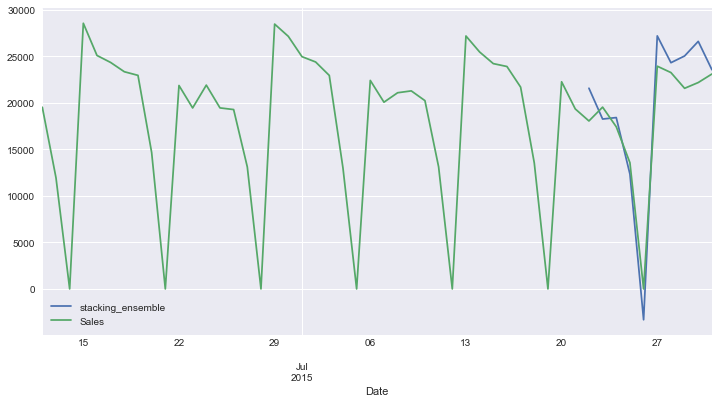

In [9]:
(stacking_ensemble.fit(X[:-10], y[:-10])
                  .predict(X[-10:])
                  .merge(y, left_index=True, right_index=True, how='outer')
                  .tail(50)
                  .plot()
);